In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "../input/depressiondataset/dataset_umap20_ER/"

In [3]:
val_df = pd.read_csv(path+'data/ds.tsv', sep='\t')
ts_hs = pd.read_csv(path+'data/ts_hs.tsv', sep='\t')
ts_ht = pd.read_csv(path+"data/ts_ht.tsv", sep='\t') 

In [4]:
data = pd.concat([ts_hs, ts_ht], ignore_index=True)
data.shape

(14000, 6)

# Bidirectional Encoder Representations from Tranformers (BERT)

In [5]:
%%capture
!pip install transformers
!pip install torchmetrics

In [6]:
import torch
from torch import nn 
from transformers import BertTokenizer
from transformers import BertModel
from torchmetrics.functional import recall, precision, f1_score

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', lowercase=True)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['label'].tolist()
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['pp_text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y



np.random.seed(112)
df_train, df_val = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(data))])

print(len(df_train),len(df_val))

11200 2800


In [11]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [12]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            train_losses.append(total_loss_train / len(train_data))
            train_acc.append(total_acc_train / len(train_data))

            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                val_losses.append(total_loss_val / len(val_data))
                val_acc.append(total_acc_val / len(val_data))
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
    
    return (train_losses, train_acc, val_losses, val_acc)




In [13]:
EPOCHS = 4
model = BertClassifier()
LR = 2e-5
              
history = train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 700/700 [09:18<00:00,  1.25it/s]


Epochs: 1 | Train Loss:  0.028 | Train Accuracy:  0.791 | Val Loss:  0.025 | Val Accuracy:  0.823


100%|██████████| 700/700 [09:18<00:00,  1.25it/s]


Epochs: 2 | Train Loss:  0.017 | Train Accuracy:  0.887 | Val Loss:  0.023 | Val Accuracy:  0.850


100%|██████████| 700/700 [09:18<00:00,  1.25it/s]


Epochs: 3 | Train Loss:  0.006 | Train Accuracy:  0.966 | Val Loss:  0.028 | Val Accuracy:  0.846


100%|██████████| 700/700 [09:18<00:00,  1.25it/s]


Epochs: 4 | Train Loss:  0.003 | Train Accuracy:  0.989 | Val Loss:  0.039 | Val Accuracy:  0.841


In [14]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [15]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        
        targets = []
        outputs = []

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            outputs.append(output.argmax(dim=1).cpu())
            targets.append(test_label.cpu())
            
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
 
    outputs = np.concatenate(outputs)
    targets = np.concatenate(targets)
    
    score = f1_score(outputs, targets,average='macro')
    print(f'F1-Score: {score: .3f}')

    score = recall_score(outputs, targets, average='macro')
    print(f'Recall-Score: {score: .3f}')

    score = precision_score(outputs, targets, average='macro')
    print(f'Precision-Score: {score: .3f}')
    
    

    

    
evaluate(model, val_df[["pp_text", "label"]])

Test Accuracy:  0.878
F1-Score:  0.875
Recall-Score:  0.870
Precision-Score:  0.892


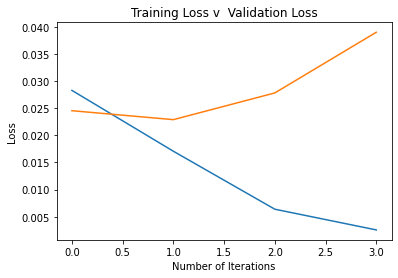

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(EPOCHS), history[0])
plt.plot(range(EPOCHS), history[2])
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training Loss v  Validation Loss")
plt.show()
plt.savefig("Loss_plot")

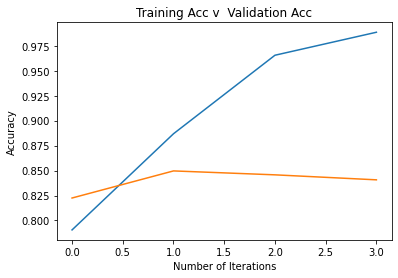

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(range(EPOCHS), history[1])
plt.plot(range(EPOCHS), history[3])
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")
plt.title("Training Acc v  Validation Acc")
plt.show()
plt.savefig("Accuracy_plot")

In [18]:
torch.save(model.state_dict(), "./saved-model")
torch.save(model, "./saved-model")